In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

In [42]:
import colorsys
import imghdr
import os
import random
from keras import backend as K

import numpy as np
from PIL import Image, ImageDraw, ImageFont

def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101)  
    random.shuffle(colors)  
    random.seed(None)  
    return colors

def scale_boxes(boxes, image_shape):
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0) 
    return image, image_data

def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    
    font = ImageFont.truetype(font='/content/drive/MyDrive/cardetection/font/FiraMono-Medium.otf',size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

In [44]:

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    box_scores = box_confidence * box_class_probs
    box_classes = K.argmax(box_scores, axis = -1)
    box_class_scores = K.max(box_scores, axis = -1, keepdims=False)
    filtering_mask = (box_class_scores >= threshold)
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    return scores, boxes, classes

In [45]:

def iou(box1, box2):
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2
    xi1 = np.maximum(box1[0], box2[0])
    yi1 = np.maximum(box1[1], box2[1])
    xi2 = np.minimum(box1[2], box2[2])
    yi2 = np.minimum(box1[3], box2[3])
    inter_width = xi2-xi1
    inter_height = yi2-yi1
    inter_area = max(inter_width, 0) * max(inter_height, 0)
    box1_area = (box1[2]-box1[0])*(box1[3]-box1[1])
    box2_area = (box2[2]-box2[0])*(box2[3]-box2[1])
    union_area = box1_area + box2_area - inter_area
    iou = float(inter_area)/float(union_area)
    return iou

In [46]:
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou for intersecting boxes = " + str(iou(box1, box2)))

box1 = (1,2,3,4)
box2 = (5,6,7,8)
print("iou for non-intersecting boxes = " + str(iou(box1,box2)))

box1 = (1,1,2,2)
box2 = (2,2,3,3)
print("iou for boxes that only touch at vertices = " + str(iou(box1,box2)))

box1 = (1,1,3,3)
box2 = (2,3,3,4)
print("iou for boxes that only touch at edges = " + str(iou(box1,box2)))

iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0


In [47]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) 
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=max_boxes, iou_threshold=iou_threshold)
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [49]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    return scores, boxes, classes

In [51]:
sess = K.get_session()

In [52]:
class_names = read_classes("/content/drive/MyDrive/cardetection/model_data/coco_classes.txt")
anchors = read_anchors("/content/drive/MyDrive/cardetection/model_data/yolo_anchors.txt")
image_shape = (720., 1280.)    

In [53]:
!pip install tensorflow==1.14.0 
!pip install keras==2.3.1
# to and keras to 2.3.1 fix the problem

In [54]:
yolo_model = load_model("/content/drive/MyDrive/cardetection/model_data/yolo.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [55]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [56]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [57]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [66]:
import imageio
def predict(sess, image_file):
    image, image_data = preprocess_image(image_file, model_image_size = (608, 608))
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})
    font = ImageFont.load_default()
    font_type = ImageFont.truetype("/content/drive/MyDrive/cardetection/font/FiraMono-Medium.otf", 18)
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    colors = generate_colors(class_names)
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    image.save(os.path.join("/content/drive/MyDrive/cardetection/images/out", image_file), quality=90)
    output_image = imageio.imread(os.path.join("/content/drive/MyDrive/cardetection/images/out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Found 2 boxes for /content/drive/MyDrive/cardetection/images/test.jpg
car 0.76 (359, 295) (747, 652)
car 0.78 (942, 327) (1280, 695)


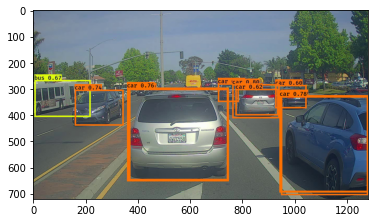

In [67]:
out_scores, out_boxes, out_classes = predict(sess, "/content/drive/MyDrive/cardetection/images/test.jpg")

**Expected Output**:

<table>
    <tr>
        <td>
            **Found 7 boxes for test.jpg**
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.60 (925, 285) (1045, 374)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.66 (706, 279) (786, 350)
        </td>
    </tr>
    <tr>
        <td>
            **bus**
        </td>
        <td>
           0.67 (5, 266) (220, 407)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.70 (947, 324) (1280, 705)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.74 (159, 303) (346, 440)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.80 (761, 282) (942, 412)
        </td>
    </tr>
    <tr>
        <td>
            **car**
        </td>
        <td>
           0.89 (367, 300) (745, 648)
        </td>
    </tr>
</table>

**Car detection dataset**:
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" />